In [166]:
import itertools
import pandas as pd
import numpy as np
import pylab
import statsmodels
import scipy

import matplotlib.pyplot as plt
from scipy.stats import probplot
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import *

%pylab inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний  о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:

* state — штат США
* account_length — длительность использования аккаунта
* area_code — деление пользователей на псевдорегионы, использующееся в телекоме
* intl_plan — подключена ли у пользователя услуга международного общения
* vmail_plan — подключена ли у пользователя услуга голосовых сообщений
* vmail_message — количество голосовых сообщений, который пользователь отправил / принял
* day_calls — сколько пользователь совершил дневных звонков
* day_mins — сколько пользователь проговорил минут в течение дня
* day_charge — сколько пользователь заплатил за свою дневную активность
* eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
* night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
* intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
* custserv_calls — сколько раз пользователь позвонил в службу поддержки
* treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
* mes_estim — оценка интенсивности пользования интернет мессенджерами
* churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [167]:
data = pd.read_csv('churn_analysis.csv')

In [168]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data['churn'] = data['churn'].map({'False.': 0,'True.': 1})
data['intl_plan'] = data['intl_plan'].map({'no': 0,'yes': 1})
data['vmail_plan'] = data['vmail_plan'].map({'no': 0,'yes': 1})

In [169]:
data.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,0


### Задание 1

Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат.  Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn.

In [170]:
from itertools import combinations

control_group = data[(data['treatment'] == 1)]

states = np.unique(data['state'])

state_pairs = list(combinations(states, 2))

print('Всего пар штатов:', len(state_pairs))

Всего пар штатов: 1275


In [171]:
ct = pd.crosstab(index = control_group['state'], columns = control_group['churn'],
                 values = control_group['churn'], aggfunc = len)

ct.head()

churn,0,1
state,,
AK,19.0,1.0
AL,25.0,5.0
AR,11.0,5.0
AZ,17.0,2.0
CA,10.0,5.0


In [172]:
chi2_ps = []

for i in range(len(state_pairs)):
    chi2_ps.append(stats.chi2_contingency(ct.loc[state_pairs[i], :].fillna(0), correction=False)[1])


In [173]:
print(np.sum(np.asarray(chi2_ps) < .05), 'достигаемых уровней значимости оказались меньше 0,05')

34 достигаемых уровней значимости оказались меньше 0,05


In [174]:
stats.chi2_contingency(ct.fillna(0), correction=False)[1]

0.7097590042778473

В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в  таблице сопряженности  может быть аппроксимировано с помощью непрерывного распределения xи-квадрат.  Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность.  Эта поправка заключается в  вычитании константы 0.5  из каждого модуля разности наблюденного $$O_i$$ и ожидаемого $$E_i$$ значений, то есть, статистика с такой поправкой выглядит так:
$$\chi^2_{Yates} = \sum_{i=1}^n\frac{(|O_i - E_i| - 0.5)^2}{E_i}$$

Такая поправка, как несложно догадаться по формуле, как правило, уменьшает  значение статистики  \chi^{2} χ
2
 , то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2  и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Полезно знать, что эта поправка часто включена по  умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости.

Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией

In [176]:
chi2_ps_corrected = []

for i in range(len(state_pairs)):
    chi2_ps_corrected.append(stats.chi2_contingency(ct.loc[state_pairs[i], :].fillna(0), correction=True)[1])

In [177]:
print(np.sum(np.asarray(chi2_ps_corrected) < .05), 'достигаемых уровней значимости оказались меньше 0,05 после корректировки')

0 достигаемых уровней значимости оказались меньше 0,05 после корректировки


Что если у нас мало данных,  мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку,  предположения  критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно ?

В таком случае прибегают к так называемому точному критерию Фишера. Этот  критерий не использует приближений  и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.


Тогда вероятность получить именно такие a, b, c, da,b,c,d при фиксированных значениях сумм по строкам и по столбцам) задается выражением:
$$p= \frac{\begin{pmatrix} a+ b\\a\end{pmatrix}\begin{pmatrix} c + d\\c\end{pmatrix}}{\begin{pmatrix} n\\a + c\end{pmatrix}} = \frac{(a + b)!(c + d)!(a + c)!(b + d)!}{a! b! d! c! n!}$$

В числителе этой дроби стоит суммарное количество способов выбрать a и c из a+b и c+d соответственно. А в знаменателе — количество способов выбрать число объектов, равное сумме элементов первого столбца a+c из общего количества рассматриваемых объектов n.

Чтобы посчитать достигаемый уровень значимости критерия Фишера, нужно перебрать все возможные значения a, b, c, d, в клетках этой таблицы так, чтобы построковые и постолбцовые суммы не изменились. Для каждого такого набора a, b, c, d нужно вычислить значение $$p_i$$ по формуле выше и просуммировать все такие значения $$p_i$$, которые меньше или равны p, которое мы вычислили по наблюдаемым значениям a, b, c, d.

Понятно, что такой критерий вычислительно неудобен в силу большого количества факториалов в формуле выше. То есть даже при небольших выборках для вычисления значения этого критерия приходится оперировать очень большими числами. Поэтому данным критерием пользуются обычно только для таблиц 2x2, но сам критерий никак не ограничен количеством строк и столбцов, и его можно построить для любой таблицы n×m.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

In [178]:
fisher_ps = []
for i in range(len(state_pairs)):
    fisher_ps.append(stats.fisher_exact(ct.loc[state_pairs[i], :].fillna(0))[1])

In [179]:
print(np.sum(np.asarray(fisher_ps) < .05), 'достигаемых уровней значимости оказались меньше 0,05')

10 достигаемых уровней значимости оказались меньше 0,05


Рассмотрим пару признаков day_calls и  mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость.

In [180]:
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

In [182]:
corr, p = pearsonr(data['day_calls'], data['mes_estim'])

print('R = {}\np-value = {}'.format(round(corr, 2), p))

R = -0.05
p-value = 0.0027798836869732313


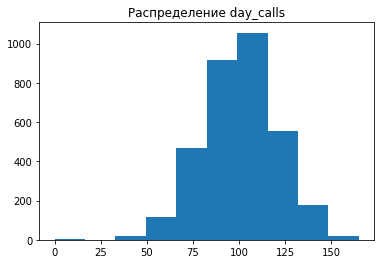

In [183]:
plt.hist(data['day_calls'])
plt.title('Распределение day_calls')
plt.show()

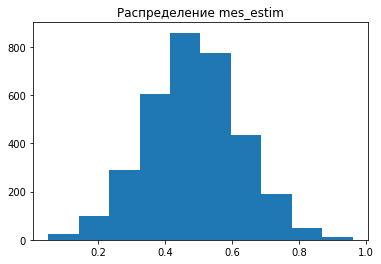

In [184]:
plt.hist(data['mes_estim'])
plt.title('Распределение mes_estim')
plt.show()

Еще раз рассмотрим пару признаков day_calls и  mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

In [185]:
from scipy.stats import spearmanr

In [187]:
corr, p = spearmanr(data['day_calls'], data['mes_estim'])

print('R = {}\np-value = {}'.format(round(corr, 2), p))

R = 0.04
p-value = 0.012317367189170543


Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

In [188]:
cramer = np.sqrt(stats.chi2_contingency(ct.fillna(0))[0]/control_group.shape[0])

print('Cramer Correlation =', round(cramer, 4))
print('p-value =', stats.chi2_contingency(ct.fillna(0))[1])

Cramer Correlation = 0.2004
p-value = 0.7097590042778473
